## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cpu


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of          depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0            1    -19.719746     471.661536  -101.200398    -231.960902   
1            2    -19.719746     471.661536  -101.200398    -231.960902   
2            3    -19.719746     471.661536  -101.200398    -231.960902   
3            4    -19.719746     471.661536  -101.200398    -231.960902   
4            5    -19.719746     471.661536  -101.200398    -231.960902   
...        ...           ...            ...          ...            ...   
1752345     46    -12.920028     494.226632   -46.982710     -95.220702   
1752346     47    -12.920028     494.226632   -46.982710     -95.220702   
1752347     48    -12.920028     494.226632   -46.982710     -95.220702   
1752348     49    -12.920028     494.226632   -46.982710     -95.220702   
1752349     50    -12.920028     494.226632   -46.982710     -95.220702   

         Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0   

In [5]:
training_frac = 0.60
depth_steps = 50
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 35047
Number of training points: 1051400


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [7]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_heat01']]

# Loading Models

In [8]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 
                 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'temp_initial00']
m0_output_columns = ['temp_heat01']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./../02_training/saved_models/heating_model_time.pth"
m0_layers = [len(m0_input_columns), 32, 32, len(m0_output_columns)]

heating_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
heating_model.load_state_dict(m0_checkpoint)
heating_model = heating_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

In [9]:
m1_input_columns =['depth', 'Area_m2', 'Uw',
                 'buoyancy', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'diffusivity', 'temp_initial00', 'temp_heat01', 'temp_total05']
m1_output_columns = ['temp_diff02']

m1_input_column_ix = [data_df.columns.get_loc(column) for column in m1_input_columns]
m1_output_column_ix = [data_df.columns.get_loc(column) for column in m1_output_columns]

m1_PATH = f"./../02_training/saved_models/diffusion_model_time.pth"
m1_layers = [len(m1_input_columns), 32, 32, len(m1_output_columns)]

heat_diff_model = MLP(m1_layers, activation="gelu")
m1_checkpoint = torch.load(m1_PATH, map_location=torch.device('cpu'))
heat_diff_model.load_state_dict(m1_checkpoint)
heat_diff_model = heat_diff_model.to(device)

Initializing Network with Xavier Initialization..


## Mixing Model

In [10]:
m2_input_columns = ['depth', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'day_of_year', 'time_of_day',
                   'ice', 'snow', 'snowice', 'temp_diff02']
m2_output_columns = ['temp_mix03']

m2_input_column_ix = [data_df.columns.get_loc(column) for column in m2_input_columns]
m2_output_column_ix = [data_df.columns.get_loc(column) for column in m2_output_columns]

m2_PATH = f"./../02_training/saved_models/mixing_model_time.pth"
m2_layers = [len(m2_input_columns), 32, 32, len(m2_output_columns)]

mixing_model = MLP(m2_layers, activation="gelu")
m2_checkpoint = torch.load(m2_PATH, map_location=torch.device('cpu'))
mixing_model.load_state_dict(m2_checkpoint)
mixing_model = mixing_model.to(device)

Initializing Network with Xavier Initialization..


# Convection Model

In [11]:
m3_input_columns =  ['depth', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice',  'temp_initial00', 'temp_heat01', 'temp_total05', 'temp_diff02']
m3_output_columns = ['temp_conv04']

m3_input_column_ix = [data_df.columns.get_loc(column) for column in m3_input_columns]
m3_output_column_ix = [data_df.columns.get_loc(column) for column in m3_output_columns]

m3_PATH = f"./../02_training/saved_models/convection_model_time.pth"
m3_layers = [len(m3_input_columns), 32, 32, len(m3_output_columns)]

convection_model = MLP(m3_layers, activation="gelu")
m3_checkpoint = torch.load(m3_PATH, map_location=torch.device('cpu'))
convection_model.load_state_dict(m3_checkpoint)
convection_model = convection_model.to(device)

Initializing Network with Xavier Initialization..


# Ice Model

In [12]:
m4_input_columns =['depth', 'day_of_year', 'time_of_day','ice', 'snow', 'snowice', 'temp_initial00', 'temp_heat01']
m4_output_columns = ['temp_total05']

m4_input_column_ix = [data_df.columns.get_loc(column) for column in m4_input_columns]
m4_output_column_ix = [data_df.columns.get_loc(column) for column in m4_output_columns]

m4_PATH = f"./../02_training/saved_models/ice_model_time.pth"
m4_layers = [len(m4_input_columns), 32, 32, len(m4_output_columns)]

ice_model = MLP(m4_layers, activation="gelu")
m4_checkpoint = torch.load(m4_PATH, map_location=torch.device('cpu'))
ice_model.load_state_dict(m4_checkpoint)
ice_model = ice_model.to(device)

Initializing Network with Xavier Initialization..


In [13]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [14]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [15]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [16]:
# Create data set
batch_size = 1000

#assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [17]:
print(train_data.shape)
print(test_data.shape)

(1051400, 45)
(700950, 45)


In [18]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [19]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [20]:
def get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, loader, plot = True):    
    heating_model.eval()
    heat_diff_model.eval()
    mixing_model.eval()
    convection_model.eval()
    ice_model.eval()

    mean = torch.tensor(train_mean[m3_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m3_output_column_ix]).float().to(device)

    m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
    m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        #model 2
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m0_pred], dim=-1)

        m4_pred = ice_model(m4_input)

        
        #print(m1_pred)
        
        if plot:
            m4_y_true = x[:, m4_output_column_ix[0]] * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
            m4_y_pred = m4_pred * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 1] = rmse(m4_y_true.squeeze(), m4_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m1", rmse(m4_y_true.flatten(), m4_y_pred.flatten()))


        #model 3
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m4_pred], dim=-1)
        m1_pred = heat_diff_model(m1_input)
            
        if plot:
            m1_y_true = x[:, m1_output_column_ix] * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            m1_y_pred = m1_pred * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            rmse_models[ix, 3] = rmse(m1_y_true.squeeze(), m1_y_pred.squeeze())
            print("RMSE of after m3", rmse(m1_y_true.flatten(), m1_y_pred.flatten()))

        #model 4
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m1_pred], dim=-1)
        m3_pred = convection_model(m3_input)
            
        if plot:
            m3_y_true = x[:, m3_output_column_ix] * std + mean
            m3_y_pred = m3_pred * std + mean
            rmse_models[ix, 4] = rmse(m3_y_true.squeeze(), m3_y_pred.squeeze())
            print("RMSE of after m4", rmse(m3_y_true.flatten(), m3_y_pred.flatten()))

        y_true = x[:, m3_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m3_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [21]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth (m)", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    yticks_ix = np.array(ax[0].get_yticks()).astype(int)
    depth_label = yticks_ix / 2
    ax[0].set_yticklabels(depth_label, rotation=0)
    ax[0].collections[0].colorbar.set_label("Actual Temperature ($^\circ$C)")

    sns.heatmap(y_pred.T, ax=ax[1], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature ($^\circ$C)")
    yticks_ix = np.array(ax[1].get_yticks()).astype(int)
    depth_label = yticks_ix / 2
    ax[1].set_yticklabels(depth_label, rotation=0)
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    yticks_ix = np.array(ax[2].get_yticks()).astype(int)
    depth_label = yticks_ix / 2
    ax[2].set_yticklabels(depth_label, rotation=0)
    ax[2].collections[0].colorbar.set_label("Absolute Error ($^\circ$C)")
    plt.show()

# Rollout Results

## Training Results

In [22]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")



RMSE of after m0 0.5314539
RMSE of after m1 0.5038529
RMSE of after m3 0.41058066
RMSE of after m4 0.40841126
RMSE of after m0 0.4850574
RMSE of after m1 0.33333546
RMSE of after m3 0.10790314
RMSE of after m4 0.11067468
RMSE of after m0 0.44246578
RMSE of after m1 0.27840084
RMSE of after m3 0.13856688
RMSE of after m4 0.13135292
RMSE of after m0 0.4490155
RMSE of after m1 0.22472136
RMSE of after m3 0.18683638
RMSE of after m4 0.18292774
RMSE of after m0 0.47466496
RMSE of after m1 0.2152792
RMSE of after m3 0.1745743
RMSE of after m4 0.17134044
RMSE of after m0 0.5345552
RMSE of after m1 0.1999057
RMSE of after m3 0.29438683
RMSE of after m4 0.2930529
RMSE of after m0 0.6256702
RMSE of after m1 0.19395098
RMSE of after m3 0.07940751
RMSE of after m4 0.07808899
RMSE of after m0 0.61222327
RMSE of after m1 0.18767081
RMSE of after m3 0.05266722
RMSE of after m4 0.051906593
RMSE of after m0 0.5868373
RMSE of after m1 0.17779528
RMSE of after m3 0.07206319
RMSE of after m4 0.068247214
R

RMSE of after m0 0.50419486
RMSE of after m1 0.12118967
RMSE of after m3 0.05469856
RMSE of after m4 0.04560864
RMSE of after m0 0.49733773
RMSE of after m1 0.120582305
RMSE of after m3 0.050933238
RMSE of after m4 0.038194545
RMSE of after m0 0.50673884
RMSE of after m1 0.122711
RMSE of after m3 0.051184196
RMSE of after m4 0.038402982
RMSE of after m0 0.5206697
RMSE of after m1 0.12561485
RMSE of after m3 0.051043168
RMSE of after m4 0.038111884
RMSE of after m0 0.5072432
RMSE of after m1 0.12098831
RMSE of after m3 0.050828297
RMSE of after m4 0.038393162
RMSE of after m0 0.51604384
RMSE of after m1 0.12351066
RMSE of after m3 0.056044664
RMSE of after m4 0.0457435
RMSE of after m0 0.5234601
RMSE of after m1 0.12623414
RMSE of after m3 0.05492543
RMSE of after m4 0.04137805
RMSE of after m0 0.52533466
RMSE of after m1 0.12719429
RMSE of after m3 0.054603007
RMSE of after m4 0.040498123
RMSE of after m0 0.5200119
RMSE of after m1 0.12541047
RMSE of after m3 0.053800493
RMSE of after 

RMSE of after m0 0.36482868
RMSE of after m1 0.31489336
RMSE of after m3 0.062129673
RMSE of after m4 0.05864202
RMSE of after m0 0.3637059
RMSE of after m1 0.31110644
RMSE of after m3 0.07118826
RMSE of after m4 0.07358937
RMSE of after m0 0.35577527
RMSE of after m1 0.30178148
RMSE of after m3 0.074975066
RMSE of after m4 0.07828218
RMSE of after m0 0.2958683
RMSE of after m1 0.24489869
RMSE of after m3 0.068077736
RMSE of after m4 0.06782035
RMSE of after m0 0.25922808
RMSE of after m1 0.21154241
RMSE of after m3 0.060419533
RMSE of after m4 0.05906215
RMSE of after m0 0.2690261
RMSE of after m1 0.2223293
RMSE of after m3 0.065469086
RMSE of after m4 0.06327805
RMSE of after m0 0.29146573
RMSE of after m1 0.24352959
RMSE of after m3 0.07173258
RMSE of after m4 0.075482816
RMSE of after m0 0.30149007
RMSE of after m1 0.2525583
RMSE of after m3 0.06414826
RMSE of after m4 0.06811149
RMSE of after m0 0.25957003
RMSE of after m1 0.21416561
RMSE of after m3 0.061140127
RMSE of after m4 0

RMSE of after m4 0.053973567
RMSE of after m0 0.2191591
RMSE of after m1 0.18913743
RMSE of after m3 0.052137278
RMSE of after m4 0.045481924
RMSE of after m0 0.22199988
RMSE of after m1 0.19337653
RMSE of after m3 0.054654513
RMSE of after m4 0.052408952
RMSE of after m0 0.22405563
RMSE of after m1 0.19509365
RMSE of after m3 0.047463268
RMSE of after m4 0.040791217
RMSE of after m0 0.24917044
RMSE of after m1 0.21721646
RMSE of after m3 0.05359639
RMSE of after m4 0.050930284
RMSE of after m0 0.2462666
RMSE of after m1 0.2165679
RMSE of after m3 0.049513474
RMSE of after m4 0.047725484
RMSE of after m0 0.23462453
RMSE of after m1 0.20503058
RMSE of after m3 0.042755827
RMSE of after m4 0.038668197
RMSE of after m0 0.22098428
RMSE of after m1 0.19087702
RMSE of after m3 0.07097737
RMSE of after m4 0.06296329
RMSE of after m0 0.21613854
RMSE of after m1 0.18476169
RMSE of after m3 0.05529219
RMSE of after m4 0.047630616
RMSE of after m0 0.22261769
RMSE of after m1 0.1930112
RMSE of aft

RMSE of after m0 0.16069366
RMSE of after m1 0.15167712
RMSE of after m3 0.05068226
RMSE of after m4 0.042800304
RMSE of after m0 0.16178906
RMSE of after m1 0.15270169
RMSE of after m3 0.059261933
RMSE of after m4 0.04433734
RMSE of after m0 0.16557693
RMSE of after m1 0.15758409
RMSE of after m3 0.058907136
RMSE of after m4 0.044325806
RMSE of after m0 0.183621
RMSE of after m1 0.18095236
RMSE of after m3 0.030623058
RMSE of after m4 0.022175629
RMSE of after m0 0.18623653
RMSE of after m1 0.18521772
RMSE of after m3 0.03682733
RMSE of after m4 0.031138819
RMSE of after m0 0.17783651
RMSE of after m1 0.17472349
RMSE of after m3 0.038307037
RMSE of after m4 0.02971941
RMSE of after m0 0.17680685
RMSE of after m1 0.17340532
RMSE of after m3 0.039780594
RMSE of after m4 0.03256806
RMSE of after m0 0.18804005
RMSE of after m1 0.18600859
RMSE of after m3 0.04024188
RMSE of after m4 0.031745348
RMSE of after m0 0.18691404
RMSE of after m1 0.18427499
RMSE of after m3 0.03486462
RMSE of afte

RMSE of after m0 0.69081503
RMSE of after m1 0.2649174
RMSE of after m3 0.13071327
RMSE of after m4 0.12526758
RMSE of after m0 0.68844664
RMSE of after m1 0.2589768
RMSE of after m3 0.12953328
RMSE of after m4 0.12512332
RMSE of after m0 0.68305343
RMSE of after m1 0.2526973
RMSE of after m3 0.12181561
RMSE of after m4 0.1179736
RMSE of after m0 0.6517496
RMSE of after m1 0.2532765
RMSE of after m3 0.09047549
RMSE of after m4 0.08651279
RMSE of after m0 0.6516688
RMSE of after m1 0.24933131
RMSE of after m3 0.10520233
RMSE of after m4 0.1002574
RMSE of after m0 0.6531937
RMSE of after m1 0.2466741
RMSE of after m3 0.09651198
RMSE of after m4 0.091607764
RMSE of after m0 0.64930207
RMSE of after m1 0.24399513
RMSE of after m3 0.09995764
RMSE of after m4 0.09463186
RMSE of after m0 0.64612925
RMSE of after m1 0.2395293
RMSE of after m3 0.10956663
RMSE of after m4 0.10291535
RMSE of after m0 0.65579534
RMSE of after m1 0.2397391
RMSE of after m3 0.09766728
RMSE of after m4 0.092335336
RM

RMSE of after m3 0.05218836
RMSE of after m4 0.05167277
RMSE of after m0 0.5794499
RMSE of after m1 0.15670244
RMSE of after m3 0.049594276
RMSE of after m4 0.049389623
RMSE of after m0 0.5820948
RMSE of after m1 0.15584482
RMSE of after m3 0.043964032
RMSE of after m4 0.04438191
RMSE of after m0 0.5868513
RMSE of after m1 0.15594605
RMSE of after m3 0.051624577
RMSE of after m4 0.051595956
RMSE of after m0 0.58719397
RMSE of after m1 0.15667722
RMSE of after m3 0.047960453
RMSE of after m4 0.047659766
RMSE of after m0 0.5804504
RMSE of after m1 0.15515253
RMSE of after m3 0.05042493
RMSE of after m4 0.05018496
RMSE of after m0 0.58312345
RMSE of after m1 0.15498088
RMSE of after m3 0.052280795
RMSE of after m4 0.05234113
RMSE of after m0 0.5811458
RMSE of after m1 0.15468802
RMSE of after m3 0.0528125
RMSE of after m4 0.05271915
RMSE of after m0 0.57844234
RMSE of after m1 0.1529582
RMSE of after m3 0.043344736
RMSE of after m4 0.044065557
RMSE of after m0 0.58576924
RMSE of after m1 

RMSE of after m0 0.62140924
RMSE of after m1 0.13732177
RMSE of after m3 0.036426242
RMSE of after m4 0.035320304
RMSE of after m0 0.6194037
RMSE of after m1 0.13692936
RMSE of after m3 0.050355505
RMSE of after m4 0.046685178
RMSE of after m0 0.6161852
RMSE of after m1 0.1361489
RMSE of after m3 0.056587685
RMSE of after m4 0.05548395
RMSE of after m0 0.6370799
RMSE of after m1 0.14002624
RMSE of after m3 0.059892368
RMSE of after m4 0.057274193
RMSE of after m0 0.6387295
RMSE of after m1 0.13842714
RMSE of after m3 0.06609564
RMSE of after m4 0.06510611
RMSE of after m0 0.6423055
RMSE of after m1 0.13780157
RMSE of after m3 0.05747045
RMSE of after m4 0.05543573
RMSE of after m0 0.6450884
RMSE of after m1 0.13832226
RMSE of after m3 0.050825045
RMSE of after m4 0.04793609
RMSE of after m0 0.6849625
RMSE of after m1 0.14330041
RMSE of after m3 0.041207377
RMSE of after m4 0.042160563
RMSE of after m0 0.6700835
RMSE of after m1 0.13779658
RMSE of after m3 0.04516347
RMSE of after m4 0.

RMSE of after m0 0.30231768
RMSE of after m1 0.24217303
RMSE of after m3 0.06639649
RMSE of after m4 0.06555871
RMSE of after m0 0.30787158
RMSE of after m1 0.24763507
RMSE of after m3 0.06573081
RMSE of after m4 0.06480682
RMSE of after m0 0.31356946
RMSE of after m1 0.2512219
RMSE of after m3 0.069183975
RMSE of after m4 0.06934472
RMSE of after m0 0.30472437
RMSE of after m1 0.24341185
RMSE of after m3 0.07927066
RMSE of after m4 0.07689539
RMSE of after m0 0.2833442
RMSE of after m1 0.21992773
RMSE of after m3 0.09419135
RMSE of after m4 0.0846769
RMSE of after m0 0.28908658
RMSE of after m1 0.22867657
RMSE of after m3 0.080812685
RMSE of after m4 0.07346174
RMSE of after m0 0.29259503
RMSE of after m1 0.23547305
RMSE of after m3 0.067224234
RMSE of after m4 0.065221034
RMSE of after m0 0.29782107
RMSE of after m1 0.24207361
RMSE of after m3 0.06726929
RMSE of after m4 0.06695178
RMSE of after m0 0.31534624
RMSE of after m1 0.25690103
RMSE of after m3 0.06804007
RMSE of after m4 0.

RMSE of after m0 0.20715177
RMSE of after m1 0.18891001
RMSE of after m3 0.039670035
RMSE of after m4 0.035045326
RMSE of after m0 0.22062768
RMSE of after m1 0.19810222
RMSE of after m3 0.039370216
RMSE of after m4 0.037532378
RMSE of after m0 0.22072545
RMSE of after m1 0.19936581
RMSE of after m3 0.044985186
RMSE of after m4 0.04163325
RMSE of after m0 0.21940345
RMSE of after m1 0.19855021
RMSE of after m3 0.046866678
RMSE of after m4 0.041591853
RMSE of after m0 0.21931846
RMSE of after m1 0.19959983
RMSE of after m3 0.046223886
RMSE of after m4 0.041044753
RMSE of after m0 0.21453914
RMSE of after m1 0.19581659
RMSE of after m3 0.042100657
RMSE of after m4 0.034938008
RMSE of after m0 0.20449395
RMSE of after m1 0.1879623
RMSE of after m3 0.04895834
RMSE of after m4 0.0392746
RMSE of after m0 0.19951737
RMSE of after m1 0.18282531
RMSE of after m3 0.0494817
RMSE of after m4 0.04309218
RMSE of after m0 0.21670757
RMSE of after m1 0.19624846
RMSE of after m3 0.05736594
RMSE of afte

RMSE of after m0 0.22515503
RMSE of after m1 0.21685962
RMSE of after m3 0.043446098
RMSE of after m4 0.04591494
RMSE of after m0 0.19506608
RMSE of after m1 0.18763916
RMSE of after m3 0.046166904
RMSE of after m4 0.036449414
RMSE of after m0 0.2016933
RMSE of after m1 0.19502838
RMSE of after m3 0.05589524
RMSE of after m4 0.044918638
RMSE of after m0 0.23259692
RMSE of after m1 0.2242179
RMSE of after m3 0.06615876
RMSE of after m4 0.06254453
RMSE of after m0 0.21113648
RMSE of after m1 0.20268644
RMSE of after m3 0.04942957
RMSE of after m4 0.049198292
RMSE of after m0 0.18935922
RMSE of after m1 0.18258727
RMSE of after m3 0.05342928
RMSE of after m4 0.053861026
RMSE of after m0 0.20362273
RMSE of after m1 0.19952878
RMSE of after m3 0.051548842
RMSE of after m4 0.0427675
RMSE of after m0 0.21901558
RMSE of after m1 0.21542932
RMSE of after m3 0.04828438
RMSE of after m4 0.03981788
RMSE of after m0 0.24910611
RMSE of after m1 0.24513997
RMSE of after m3 0.05812251
RMSE of after m4

RMSE of after m0 0.591504
RMSE of after m1 0.49942568
RMSE of after m3 0.2391631
RMSE of after m4 0.23401955
RMSE of after m0 0.62014556
RMSE of after m1 0.5181786
RMSE of after m3 0.21678887
RMSE of after m4 0.21703465
RMSE of after m0 0.7060387
RMSE of after m1 0.508918
RMSE of after m3 0.24086438
RMSE of after m4 0.24150418
RMSE of after m0 0.6567076
RMSE of after m1 0.3463163
RMSE of after m3 0.22382422
RMSE of after m4 0.22338593
RMSE of after m0 0.6519644
RMSE of after m1 0.33427918
RMSE of after m3 0.18317378
RMSE of after m4 0.18186346
RMSE of after m0 0.6598886
RMSE of after m1 0.32844135
RMSE of after m3 0.149748
RMSE of after m4 0.14682299
RMSE of after m0 0.67581797
RMSE of after m1 0.33194724
RMSE of after m3 0.16151735
RMSE of after m4 0.15852438
RMSE of after m0 0.67346144
RMSE of after m1 0.3323516
RMSE of after m3 0.16805944
RMSE of after m4 0.16523328
RMSE of after m0 0.6711105
RMSE of after m1 0.3314866
RMSE of after m3 0.16477706
RMSE of after m4 0.16216466
RMSE of 

RMSE of after m0 0.61294305
RMSE of after m1 0.14144969
RMSE of after m3 0.03736132
RMSE of after m4 0.034777585
RMSE of after m0 0.6016811
RMSE of after m1 0.13947992
RMSE of after m3 0.04063469
RMSE of after m4 0.03638756
RMSE of after m0 0.6075238
RMSE of after m1 0.14112052
RMSE of after m3 0.057061903
RMSE of after m4 0.05279995
RMSE of after m0 0.6317741
RMSE of after m1 0.14435732
RMSE of after m3 0.10439397
RMSE of after m4 0.097053
RMSE of after m0 0.6403502
RMSE of after m1 0.14671467
RMSE of after m3 0.15019421
RMSE of after m4 0.13763477
RMSE of after m0 0.62676847
RMSE of after m1 0.14213672
RMSE of after m3 0.03340866
RMSE of after m4 0.031564362
RMSE of after m0 0.62171566
RMSE of after m1 0.14110851
RMSE of after m3 0.038398553
RMSE of after m4 0.03516683
RMSE of after m0 0.6197014
RMSE of after m1 0.14374161
RMSE of after m3 0.044031266
RMSE of after m4 0.038581282
RMSE of after m0 0.6162542
RMSE of after m1 0.14489233
RMSE of after m3 0.044170562
RMSE of after m4 0.03

RMSE of after m0 0.51215446
RMSE of after m1 0.38299978
RMSE of after m3 0.15409145
RMSE of after m4 0.15402757
RMSE of after m0 0.5059468
RMSE of after m1 0.3772095
RMSE of after m3 0.14300233
RMSE of after m4 0.14130028
RMSE of after m0 0.49697563
RMSE of after m1 0.36867702
RMSE of after m3 0.14349471
RMSE of after m4 0.1425949
RMSE of after m0 0.5053213
RMSE of after m1 0.37758547
RMSE of after m3 0.14451756
RMSE of after m4 0.1427232
RMSE of after m0 0.5030024
RMSE of after m1 0.37975383
RMSE of after m3 0.13198906
RMSE of after m4 0.13067299
RMSE of after m0 0.48337954
RMSE of after m1 0.36439535
RMSE of after m3 0.12348259
RMSE of after m4 0.123623475
RMSE of after m0 0.44519752
RMSE of after m1 0.33155712
RMSE of after m3 0.12480642
RMSE of after m4 0.12418048
RMSE of after m0 0.45377567
RMSE of after m1 0.34852478
RMSE of after m3 0.19192469
RMSE of after m4 0.19173513
RMSE of after m0 0.4756061
RMSE of after m1 0.37752485
RMSE of after m3 0.13713701
RMSE of after m4 0.1359963

In [23]:
print(train_data.shape)
print(test_data.shape)
print(train_y_pred.shape)

(1051400, 45)
(700950, 45)
torch.Size([1051400, 1])


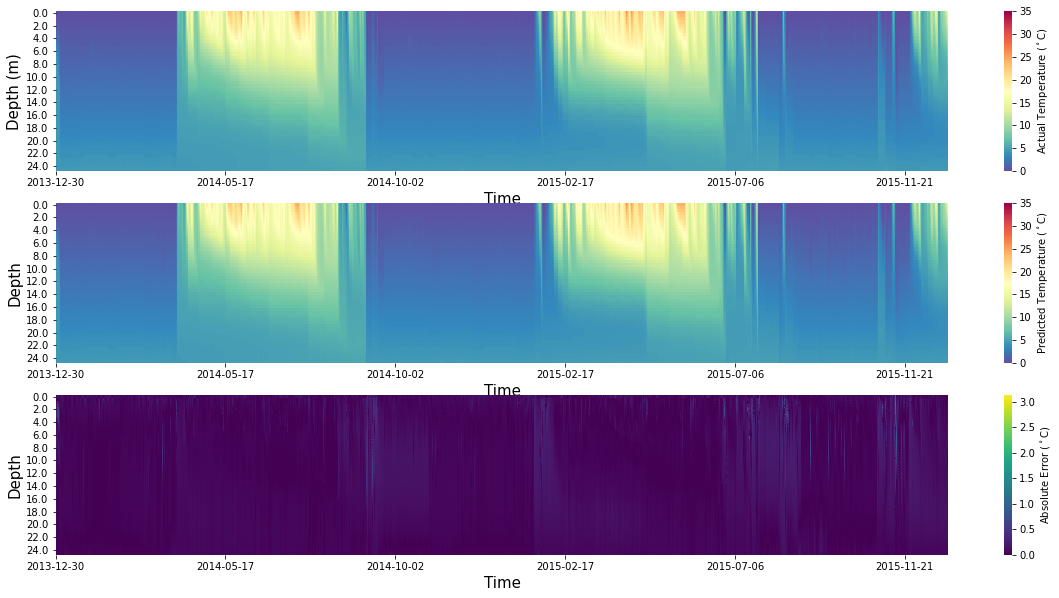

In [24]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

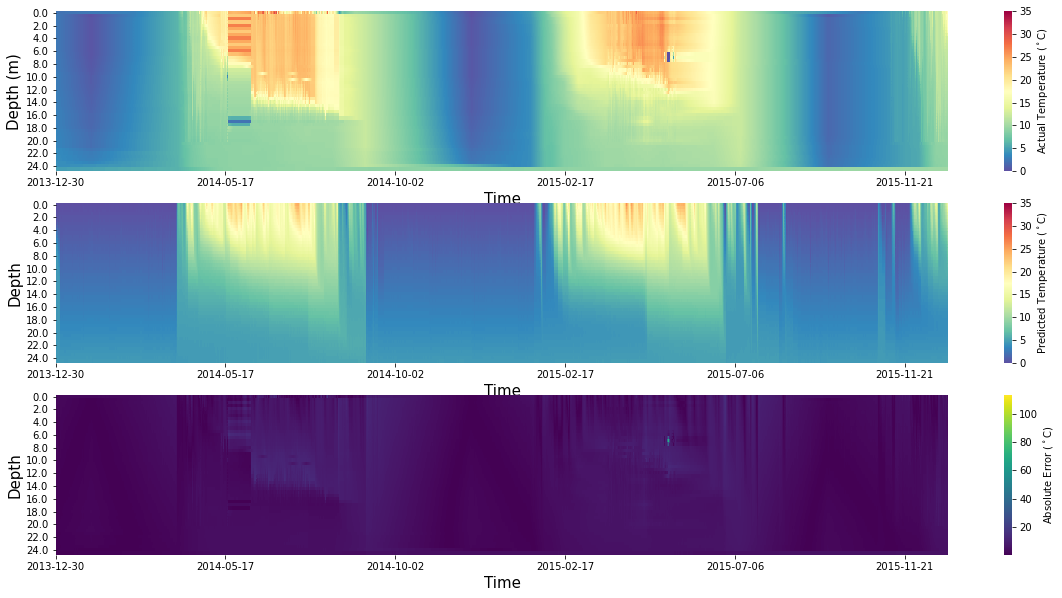

In [25]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [26]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model,heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.37945697
RMSE of after m1 0.300239
RMSE of after m3 0.08865369
RMSE of after m4 0.08818383
RMSE of after m0 0.38390532
RMSE of after m1 0.30329219
RMSE of after m3 0.09133098
RMSE of after m4 0.09113824
RMSE of after m0 0.38004932
RMSE of after m1 0.30009243
RMSE of after m3 0.090883784
RMSE of after m4 0.09034467
RMSE of after m0 0.37820458
RMSE of after m1 0.2988476
RMSE of after m3 0.09658559
RMSE of after m4 0.0970115
RMSE of after m0 0.3822854
RMSE of after m1 0.30282247
RMSE of after m3 0.08766142
RMSE of after m4 0.08635514
RMSE of after m0 0.36943722
RMSE of after m1 0.29134575
RMSE of after m3 0.077752866
RMSE of after m4 0.076139964
RMSE of after m0 0.34807777
RMSE of after m1 0.2716508
RMSE of after m3 0.08500614
RMSE of after m4 0.08166338
RMSE of after m0 0.34365284
RMSE of after m1 0.26721004
RMSE of after m3 0.08354592
RMSE of after m4 0.08251415
RMSE of after m0 0.35424578
RMSE of after m1 0.27684575
RMSE of after m3 0.08952867
RMSE of after m4 0.0883

RMSE of after m3 0.07331961
RMSE of after m4 0.07178112
RMSE of after m0 0.29662374
RMSE of after m1 0.247418
RMSE of after m3 0.072278485
RMSE of after m4 0.06678565
RMSE of after m0 0.29960877
RMSE of after m1 0.25081596
RMSE of after m3 0.06948666
RMSE of after m4 0.06704483
RMSE of after m0 0.3001285
RMSE of after m1 0.2496032
RMSE of after m3 0.07232667
RMSE of after m4 0.07064436
RMSE of after m0 0.29470456
RMSE of after m1 0.24427775
RMSE of after m3 0.07258238
RMSE of after m4 0.07156434
RMSE of after m0 0.30441597
RMSE of after m1 0.25289872
RMSE of after m3 0.07172458
RMSE of after m4 0.06996958
RMSE of after m0 0.31066227
RMSE of after m1 0.25917596
RMSE of after m3 0.06918559
RMSE of after m4 0.06787615
RMSE of after m0 0.31672755
RMSE of after m1 0.2654063
RMSE of after m3 0.069108926
RMSE of after m4 0.068408124
RMSE of after m0 0.32698447
RMSE of after m1 0.27345386
RMSE of after m3 0.0820303
RMSE of after m4 0.08259919
RMSE of after m0 0.31884643
RMSE of after m1 0.2658

RMSE of after m0 0.2827379
RMSE of after m1 0.2480655
RMSE of after m3 0.056743454
RMSE of after m4 0.054572005
RMSE of after m0 0.26064196
RMSE of after m1 0.22424999
RMSE of after m3 0.060551126
RMSE of after m4 0.05381375
RMSE of after m0 0.24946342
RMSE of after m1 0.21249679
RMSE of after m3 0.073827095
RMSE of after m4 0.06159853
RMSE of after m0 0.25861588
RMSE of after m1 0.22439013
RMSE of after m3 0.080325
RMSE of after m4 0.069049194
RMSE of after m0 0.29518738
RMSE of after m1 0.2641693
RMSE of after m3 0.07071063
RMSE of after m4 0.056272328
RMSE of after m0 0.327258
RMSE of after m1 0.2930768
RMSE of after m3 0.11515527
RMSE of after m4 0.123509444
RMSE of after m0 0.2772761
RMSE of after m1 0.24425682
RMSE of after m3 0.061310865
RMSE of after m4 0.057815224
RMSE of after m0 0.2948067
RMSE of after m1 0.25878188
RMSE of after m3 0.0810717
RMSE of after m4 0.08946731
RMSE of after m0 0.26631847
RMSE of after m1 0.23238187
RMSE of after m3 0.06862824
RMSE of after m4 0.064

RMSE of after m0 0.6555536
RMSE of after m1 0.2672276
RMSE of after m3 0.082939506
RMSE of after m4 0.08080614
RMSE of after m0 0.6314986
RMSE of after m1 0.26438442
RMSE of after m3 0.07305236
RMSE of after m4 0.07090875
RMSE of after m0 0.6298954
RMSE of after m1 0.262612
RMSE of after m3 0.11062882
RMSE of after m4 0.10876626
RMSE of after m0 0.634629
RMSE of after m1 0.26322752
RMSE of after m3 0.09887443
RMSE of after m4 0.09729473
RMSE of after m0 0.6296688
RMSE of after m1 0.26119924
RMSE of after m3 0.086276546
RMSE of after m4 0.08438239
RMSE of after m0 0.6273807
RMSE of after m1 0.25982583
RMSE of after m3 0.099079475
RMSE of after m4 0.09685755
RMSE of after m0 0.632149
RMSE of after m1 0.26118657
RMSE of after m3 0.10146584
RMSE of after m4 0.09920453
RMSE of after m0 0.6156226
RMSE of after m1 0.22570121
RMSE of after m3 0.08549073
RMSE of after m4 0.08478225
RMSE of after m0 0.6101198
RMSE of after m1 0.19293667
RMSE of after m3 0.06622919
RMSE of after m4 0.06507608
RMS

RMSE of after m0 0.6706616
RMSE of after m1 0.15140313
RMSE of after m3 0.047459584
RMSE of after m4 0.046333313
RMSE of after m0 0.66230357
RMSE of after m1 0.15326293
RMSE of after m3 0.040126648
RMSE of after m4 0.03980062
RMSE of after m0 0.6518453
RMSE of after m1 0.15160763
RMSE of after m3 0.03916039
RMSE of after m4 0.03912849
RMSE of after m0 0.6498485
RMSE of after m1 0.15163687
RMSE of after m3 0.04845962
RMSE of after m4 0.04744244
RMSE of after m0 0.6587503
RMSE of after m1 0.15234931
RMSE of after m3 0.03949423
RMSE of after m4 0.038049992
RMSE of after m0 0.67310166
RMSE of after m1 0.15384746
RMSE of after m3 0.03545904
RMSE of after m4 0.034120653
RMSE of after m0 0.7184681
RMSE of after m1 0.1645272
RMSE of after m3 0.054176077
RMSE of after m4 0.049060598
RMSE of after m0 0.8339284
RMSE of after m1 0.208086
RMSE of after m3 0.1517036
RMSE of after m4 0.13032947
RMSE of after m0 0.70724666
RMSE of after m1 0.1800079
RMSE of after m3 0.09673503
RMSE of after m4 0.08226

RMSE of after m0 0.38161278
RMSE of after m1 0.3297944
RMSE of after m3 0.10388886
RMSE of after m4 0.10411386
RMSE of after m0 0.3804422
RMSE of after m1 0.32738805
RMSE of after m3 0.09934906
RMSE of after m4 0.098109
RMSE of after m0 0.37061742
RMSE of after m1 0.31895113
RMSE of after m3 0.09378703
RMSE of after m4 0.091262594
RMSE of after m0 0.36339134
RMSE of after m1 0.31248915
RMSE of after m3 0.093988635
RMSE of after m4 0.09163295
RMSE of after m0 0.3509895
RMSE of after m1 0.30101648
RMSE of after m3 0.08778287
RMSE of after m4 0.08592528
RMSE of after m0 0.3445204
RMSE of after m1 0.29627463
RMSE of after m3 0.08895176
RMSE of after m4 0.08802479
RMSE of after m0 0.34928942
RMSE of after m1 0.30223826
RMSE of after m3 0.08378611
RMSE of after m4 0.084002584
RMSE of after m0 0.344838
RMSE of after m1 0.2966752
RMSE of after m3 0.08289374
RMSE of after m4 0.08219684
RMSE of after m0 0.34928292
RMSE of after m1 0.30086213
RMSE of after m3 0.08753121
RMSE of after m4 0.0857642

RMSE of after m3 0.04731143
RMSE of after m4 0.048372045
RMSE of after m0 0.21887995
RMSE of after m1 0.2012031
RMSE of after m3 0.045367077
RMSE of after m4 0.0433759
RMSE of after m0 0.21649027
RMSE of after m1 0.19911733
RMSE of after m3 0.054602068
RMSE of after m4 0.049270358
RMSE of after m0 0.20359948
RMSE of after m1 0.18881626
RMSE of after m3 0.055206165
RMSE of after m4 0.05047086
RMSE of after m0 0.2112422
RMSE of after m1 0.19253068
RMSE of after m3 0.05474252
RMSE of after m4 0.05200971
RMSE of after m0 0.2268254
RMSE of after m1 0.20646077
RMSE of after m3 0.048886042
RMSE of after m4 0.047665313
RMSE of after m0 0.22999245
RMSE of after m1 0.20944212
RMSE of after m3 0.04541606
RMSE of after m4 0.047752634
RMSE of after m0 0.22265168
RMSE of after m1 0.20498793
RMSE of after m3 0.04694166
RMSE of after m4 0.045829184
RMSE of after m0 0.23083839
RMSE of after m1 0.21207313
RMSE of after m3 0.05048135
RMSE of after m4 0.048710342
RMSE of after m0 0.22688529
RMSE of after 

RMSE of after m0 0.19684698
RMSE of after m1 0.18516801
RMSE of after m3 0.038740672
RMSE of after m4 0.03391283
RMSE of after m0 0.22850077
RMSE of after m1 0.2138793
RMSE of after m3 0.056674518
RMSE of after m4 0.060098823
RMSE of after m0 0.20997792
RMSE of after m1 0.19712614
RMSE of after m3 0.04593473
RMSE of after m4 0.045797825
RMSE of after m0 0.20591393
RMSE of after m1 0.19361912
RMSE of after m3 0.038286902
RMSE of after m4 0.035091683
RMSE of after m0 0.19862854
RMSE of after m1 0.18813315
RMSE of after m3 0.036093343
RMSE of after m4 0.031096434
RMSE of after m0 0.19834644
RMSE of after m1 0.18902609
RMSE of after m3 0.035679117
RMSE of after m4 0.028405197
RMSE of after m0 0.19669235
RMSE of after m1 0.18804209
RMSE of after m3 0.039787795
RMSE of after m4 0.031687424
RMSE of after m0 0.19780186
RMSE of after m1 0.18984868
RMSE of after m3 0.03610436
RMSE of after m4 0.03182646
RMSE of after m0 0.20195864
RMSE of after m1 0.19025265
RMSE of after m3 0.05071859
RMSE of a

RMSE of after m0 0.68791175
RMSE of after m1 0.35877776
RMSE of after m3 0.16839842
RMSE of after m4 0.16777425
RMSE of after m0 0.6930216
RMSE of after m1 0.35741657
RMSE of after m3 0.17067555
RMSE of after m4 0.16989392
RMSE of after m0 0.7177244
RMSE of after m1 0.37783325
RMSE of after m3 0.14116158
RMSE of after m4 0.14020303
RMSE of after m0 0.7149057
RMSE of after m1 0.3957875
RMSE of after m3 0.15533487
RMSE of after m4 0.15557557
RMSE of after m0 0.6964713
RMSE of after m1 0.3872114
RMSE of after m3 0.18589252
RMSE of after m4 0.1862729
RMSE of after m0 0.70645934
RMSE of after m1 0.39213243
RMSE of after m3 0.1912929
RMSE of after m4 0.19165386
RMSE of after m0 0.7242953
RMSE of after m1 0.4117273
RMSE of after m3 0.15978676
RMSE of after m4 0.16010511
RMSE of after m0 0.7224358
RMSE of after m1 0.5297871
RMSE of after m3 0.22191201
RMSE of after m4 0.2232597
RMSE of after m0 0.7207993
RMSE of after m1 0.53438187
RMSE of after m3 0.2772299
RMSE of after m4 0.2816315
RMSE of 

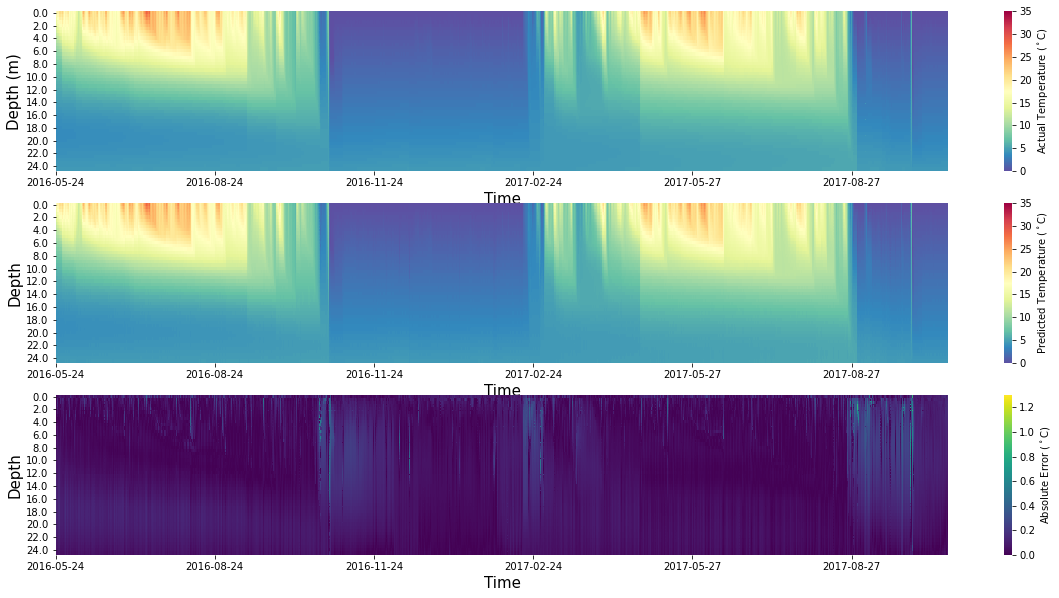

In [27]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

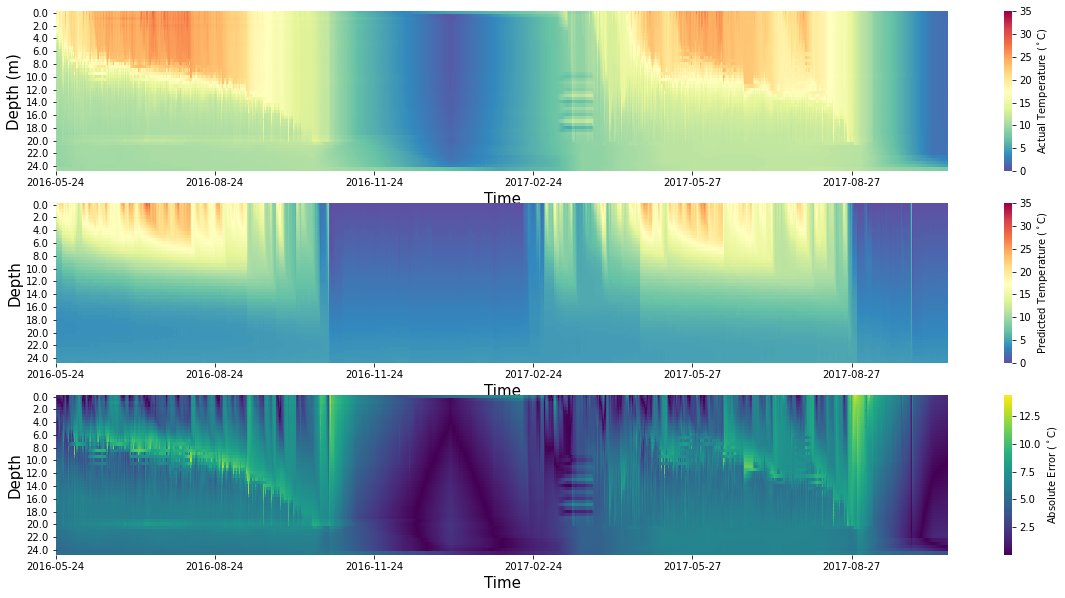

In [28]:
plot_output(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [29]:
train_rmse, train_l2_err = compute_metrics( heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.06739466436865621, Train L2 Error: 0.009749370526405815
Test RMSE: 0.05882914685676653, Train L2 Error: 0.0068004466342278065


## Mixing Model

## Convection Model

In [30]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.015163809986818539, Train L2 Error: 0.0021937284522527715
Test RMSE: 0.017966176629548223, Train L2 Error: 0.0020769408634678894


## Ice Model

In [31]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.03333344809130799, Train L2 Error: 0.004818688855386128
Test RMSE: 0.03919173269229461, Train L2 Error: 0.004527230384818891


In [32]:
def plot_output_test(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    times = time_label
    
    print(times)
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)


    sns.heatmap(y_pred.T, ax=ax, cmap='Spectral_r', vmin=0., vmax=35.)
    ax.set_ylabel("Depth (m)", fontsize=15)
    ax.set_xlabel("", fontsize=15)
    
    #  plt.legend(fontsize='x-large', title_fontsize='40')
    # ax.xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    # ax.set_xticklabels(time_label, rotation=0)
    # new insert
    xticks_ix = np.array(ax.get_xticks()).astype(int)
    
    print(xticks_ix)
    
    time_label = times[xticks_ix]
    
    print(time_label)
    
    nelement = len(time_label)//N_pts
    
    print(nelement)
    
    time_label = time_label[::nelement]
    
    print(time_label)
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax.set_xticklabels(time_label, rotation=0, fontsize = 15)
    # old code
    ax.collections[0].colorbar.set_label("Predicted Temperature ($^\circ$C)", fontsize = 15)
    yticks_ix = np.array(ax.get_yticks()).astype(int)
    
    print(yticks_ix)
    
    # depth_label = depth_steps / 25
    depth_label = yticks_ix / 2
    
    print(depth_label)
    
    nelement = len(depth_label)//5
    
    print(nelement)
    
    depth_label = depth_label[::nelement]
    
    print(depth_label)
    
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.set_yticklabels(depth_label, rotation=0, fontsize = 15)

    plt.show()

['2016-05-24' '2016-05-24' '2016-05-24' ... '2017-12-28' '2017-12-28'
 '2017-12-28']
[    0   187   374   561   748   935  1122  1309  1496  1683  1870  2057
  2244  2431  2618  2805  2992  3179  3366  3553  3740  3927  4114  4301
  4488  4675  4862  5049  5236  5423  5610  5797  5984  6171  6358  6545
  6732  6919  7106  7293  7480  7667  7854  8041  8228  8415  8602  8789
  8976  9163  9350  9537  9724  9911 10098 10285 10472 10659 10846 11033
 11220 11407 11594 11781 11968 12155 12342 12529 12716 12903 13090 13277
 13464 13651 13838]
['2016-05-24' '2016-05-31' '2016-06-08' '2016-06-16' '2016-06-24'
 '2016-07-02' '2016-07-09' '2016-07-17' '2016-07-25' '2016-08-02'
 '2016-08-10' '2016-08-17' '2016-08-25' '2016-09-02' '2016-09-10'
 '2016-09-17' '2016-09-25' '2016-10-03' '2016-10-11' '2016-10-19'
 '2016-10-26' '2016-11-03' '2016-11-11' '2016-11-19' '2016-11-26'
 '2016-12-04' '2016-12-12' '2016-12-20' '2016-12-28' '2017-01-04'
 '2017-01-12' '2017-01-20' '2017-01-28' '2017-02-05' '2017-02

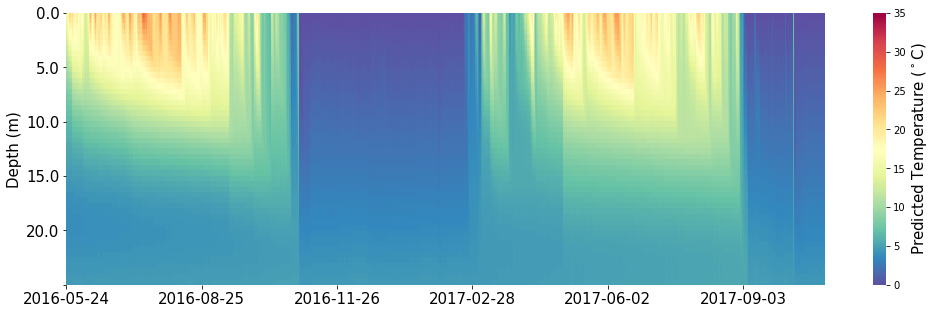

In [33]:
plot_output_test(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(17,5)) # pretraining

['2016-05-24' '2016-05-24' '2016-05-24' ... '2017-12-28' '2017-12-28'
 '2017-12-28']
[    0   187   374   561   748   935  1122  1309  1496  1683  1870  2057
  2244  2431  2618  2805  2992  3179  3366  3553  3740  3927  4114  4301
  4488  4675  4862  5049  5236  5423  5610  5797  5984  6171  6358  6545
  6732  6919  7106  7293  7480  7667  7854  8041  8228  8415  8602  8789
  8976  9163  9350  9537  9724  9911 10098 10285 10472 10659 10846 11033
 11220 11407 11594 11781 11968 12155 12342 12529 12716 12903 13090 13277
 13464 13651 13838]
['2016-05-24' '2016-05-31' '2016-06-08' '2016-06-16' '2016-06-24'
 '2016-07-02' '2016-07-09' '2016-07-17' '2016-07-25' '2016-08-02'
 '2016-08-10' '2016-08-17' '2016-08-25' '2016-09-02' '2016-09-10'
 '2016-09-17' '2016-09-25' '2016-10-03' '2016-10-11' '2016-10-19'
 '2016-10-26' '2016-11-03' '2016-11-11' '2016-11-19' '2016-11-26'
 '2016-12-04' '2016-12-12' '2016-12-20' '2016-12-28' '2017-01-04'
 '2017-01-12' '2017-01-20' '2017-01-28' '2017-02-05' '2017-02

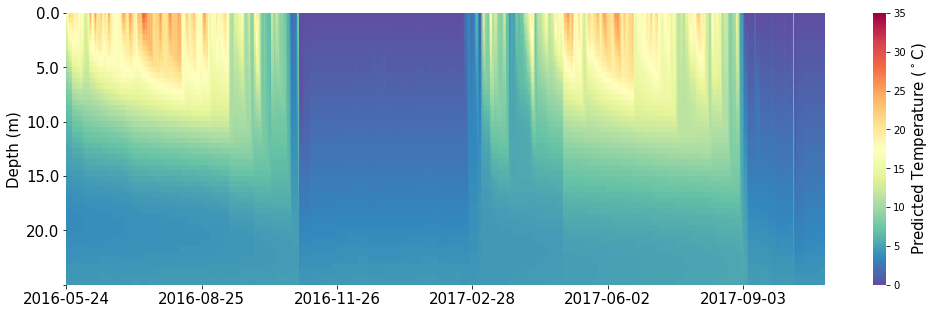

In [34]:
plot_output_test(test_y_true, test_y_obs, depth_steps, test_time, figsize=(17,5)) # process-based

['2016-05-24' '2016-05-24' '2016-05-24' ... '2017-12-28' '2017-12-28'
 '2017-12-28']
[    0   187   374   561   748   935  1122  1309  1496  1683  1870  2057
  2244  2431  2618  2805  2992  3179  3366  3553  3740  3927  4114  4301
  4488  4675  4862  5049  5236  5423  5610  5797  5984  6171  6358  6545
  6732  6919  7106  7293  7480  7667  7854  8041  8228  8415  8602  8789
  8976  9163  9350  9537  9724  9911 10098 10285 10472 10659 10846 11033
 11220 11407 11594 11781 11968 12155 12342 12529 12716 12903 13090 13277
 13464 13651 13838]
['2016-05-24' '2016-05-31' '2016-06-08' '2016-06-16' '2016-06-24'
 '2016-07-02' '2016-07-09' '2016-07-17' '2016-07-25' '2016-08-02'
 '2016-08-10' '2016-08-17' '2016-08-25' '2016-09-02' '2016-09-10'
 '2016-09-17' '2016-09-25' '2016-10-03' '2016-10-11' '2016-10-19'
 '2016-10-26' '2016-11-03' '2016-11-11' '2016-11-19' '2016-11-26'
 '2016-12-04' '2016-12-12' '2016-12-20' '2016-12-28' '2017-01-04'
 '2017-01-12' '2017-01-20' '2017-01-28' '2017-02-05' '2017-02

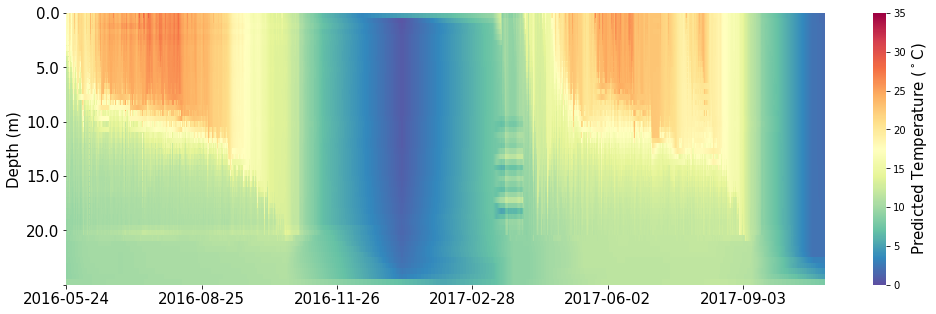

In [35]:
plot_output_test(test_y_obs, test_y_obs, depth_steps, test_time, figsize=(17,5)) # process-based

# Finetuning

# Freeze model weights